# This is a development notebook for the function aggregate_surface

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import xarray as xr
import sys
from matplotlib import pyplot as plt, cm, colors
from cmocean import cm as cmo
from datetime import datetime
from glob import glob
import yaml
#from tqdm.notebook import tqdm
sys.path.insert(
    0, 
    '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization/scripts'
)
from viz_MOHID_tools import get_MOHID_netcdf_filenames, aggregate_MOHID

%matplotlib inline
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 12})

In [2]:
# Results path
results_dir = '/scratch/dlatorne/MIDOSS/runs/monte-carlo'
# location of yaml file with runs dictionary sorted into oil types
yaml_dir = pathlib.Path(
    '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization'
)
# location to store aggregated netcdf
netcdf_dir = pathlib.Path(f'/scratch/rmueller/MIDOSS/Results') 

# NEMO meshmask
mask = xr.open_dataset(
    '/project/def-allen/rmueller/MEOPAR/grid/mesh_mask201702.nc'
)

oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]

# Specify surface level for depth slice
zlevel = 39
slc = {'grid_z': zlevel}
#slc2D = {'grid_y': slice(jmin, jmax), 'grid_x': slice(imin, imax)}

In [3]:
# %%time
# output_dir = '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization'
# files = get_MOHID_netcdf_filenames(results_dir, yaml_dir)

# This took 13 seconds to run 

## Global variables

In [4]:
# get dimensions
nruns = 5
ny,nx = 896, 396
# set dimensions for netcdf output
x, y = np.arange(0,nx), np.arange(0,ny)
# create threshold for surface volume in m3
surface_threshold = 3e-3
beach_threshold = 15e-3
Files=[]

### Call function for ANS

In [5]:
%%time
filenames_yaml = yaml_dir / 'MOHID_results_locations_07102021_15:52:22.yaml'
with filenames_yaml.open("rt") as f:
    run_paths = yaml.safe_load(f)

CPU times: user 3.03 s, sys: 28.1 ms, total: 3.06 s
Wall time: 3.2 s


In [6]:
for oil in oil_types:
    print(f'{oil}: {len(run_paths[oil])} completed runs')

akns: 53 completed runs
bunker: 2498 completed runs
dilbit: 1 completed runs
jet: 20 completed runs
diesel: 4268 completed runs
gas: 57 completed runs
other: 52 completed runs


In [7]:
%%time
#------------------------------------------------------------
# "oil" will eventually be assigned in for-loop
oil = 'akns'
#------------------------------------------------------------
# This will become 100 or more
nruns = len(run_paths[oil])
#------------------------------------------------------------
# group number will be assigned by the N groups of files 
# created by dividing the total runs in each oil type by the 
# "nruns" processed here
group = 1
#------------------------------------------------------------
# define output netcdf name
aggregated_netcdf = netcdf_dir / f'{oil}_runset{group}.nc'
#------------------------------------------------------------
# loop through and aggregate nruns in oil type
# this code will need to be updated when loop through groups is 
# introduced

mohid_in, agg_out, files = aggregate_MOHID(
    run_paths[oil], 
    surface_threshold=3e-3, 
    beach_threshold=15e-3)

CPU times: user 16.6 s, sys: 4.66 s, total: 21.3 s
Wall time: 29.7 s


In [8]:
len(files)

51

In [11]:
# Save output to netcdf
agg_out.to_netcdf(aggregated_netcdf, engine='h5netcdf')
mohid_in.to_netcdf(netcdf_dir / f'{oil}_runset{group}_AllResults.nc', engine='h5netcdf')

### Evaluate aggregation 

In [13]:
for idx,variable in enumerate([*agg_out]):
    print(f'{variable}: Min({agg_out[variable].min().item()}), Max({agg_out[variable].max().item()})')

MinBeachTime: Min(0.0), Max(58.0)
TotalBeachVolume: Min(0.0), Max(20409.271299428714)
BeachPresence: Min(0), Max(17)
BeachPresence_one: Min(0), Max(4)
BeachPresence_three: Min(0), Max(7)
BeachPresence_seven: Min(0), Max(17)


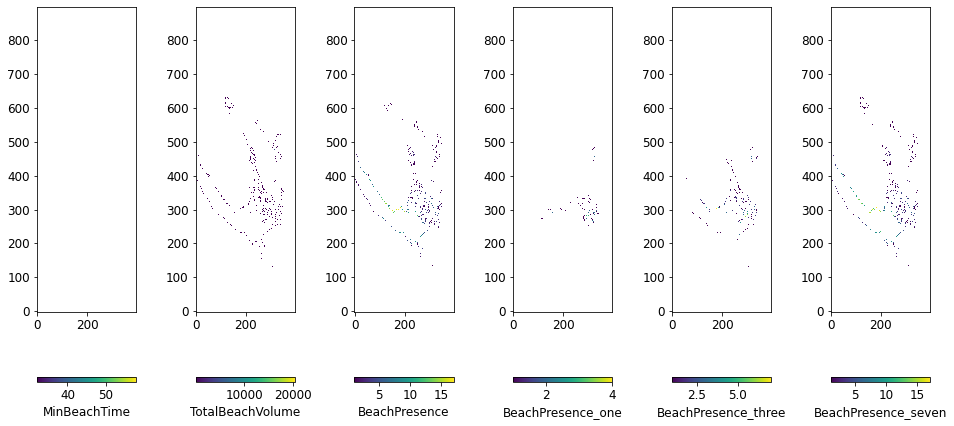

In [14]:
fig, axs = plt.subplots(1, 6, figsize=(16, 8), gridspec_kw={'wspace': 0.6, 'hspace': 0.4})
for idx,variable in enumerate([*agg_out]):
    agg_out[variable].where(agg_out[variable]>0,np.nan).plot(
        ax=axs[idx],
        cbar_kwargs={'orientation':'horizontal','spacing': 'proportional'}
    )
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')

In [23]:
print(f'MinBeachTime: Mean({agg_out.MinBeachTime.mean().item():.2e}), Median({agg_out.MinBeachTime.median().item():.2e}), Max({agg_out.MinBeachTime.max().item():.2e})')

MinBeachTime: Mean(8.77e-04), Median(0.00e+00), Max(5.80e+01)


# It gets dicey after this point

### Still remaining: 
- i,j "surface oil presence" indexing for each run to use for water column calcs
- surface presence by timing < 1 day, < 3 days, < 7 days
- yaml file with "processed runs" listed (by oil type and "all") to document which runs have been aggregated.  This file will be used together with "filenames_yaml" to identify which runs still need to be "processed"

In [ ]:
a = [True, False]
b = [True, True]
print('max(a,b):', max(a, b))
print('min(a,b):', min(a, b))

In [ ]:
np.array(a).astype(int)

### Create xarrays for aggregating beaching presence

### Define output xarrays

In [ ]:
dims = ('nspills','grid_y','grid_x')
MOHID_In = xr.Dataset(
    data_vars = dict(
        BeachTime=(dims, np.zeros((nruns,ny,nx))),
        BeachVolume=(dims, np.zeros((nruns,ny,nx),dtype=float)),
        BeachPresence=(dims, np.zeros((nruns,ny,nx),dtype=int)),
        BeachPresence_one=(dims, np.zeros((nruns,ny,nx),dtype=int)),
        BeachPresence_three=(dims, np.zeros((nruns,ny,nx),dtype=int)),
        BeachPresence_seven=(dims, np.zeros((nruns,ny,nx),dtype=int))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx))
)

dims = ('grid_y','grid_x')
Aggregate_Out = xr.Dataset(
    data_vars = dict(
        MinBeachTime=(dims, np.zeros((ny,nx)),{"units":"hours"}), #An experiment with attributing variables
        TotalBeachVolume=(dims, np.zeros((ny,nx),dtype=float)),
        BeachPresence=(dims, np.zeros((ny,nx),dtype=int)),
        BeachPresence_one=(dims, np.zeros((ny,nx),dtype=int)),
        BeachPresence_three=(dims, np.zeros((ny,nx),dtype=int)),
        BeachPresence_seven=(dims, np.zeros((ny,nx),dtype=int))), 
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        MinBeachTime_units = "hours",
        MinBeachTime="Earliest, non-zero beaching arrival time at locations where beached oil is above BeachVolume_threshold",
        TotalBeachVolume="Total volume beached over all runs where volume>BeachVolume_threshold in any given, individual run",
        TotalBeachVolume_units="meters-cubed",
        BeachVolume_threshold=beach_threshold,
        BeachVolume_threshold_units="meters-cubed",
        BeachPresence="Mask[0,1] where 1 indicates oil presence above BeachVolume_threshold",
        BeachPresence_one="Mask[0,1] where 1 indicates oil presence above BeachVolume_threshold and within the first 24 hours of spill",
        BeachPresence_three="Mask[0,1] where 1 indicates oil presence above BeachVolume_threshold and within the first 72 hours of spill",
        BeachPresence_seven="Mask[0,1] where 1 indicates oil presence above BeachVolume_threshold and within the first 168 hours of spill",

    )
)

In [ ]:
Aggregate_Out.items()

In [ ]:
# define time thresholds
one_day = np.timedelta64(24,'h')
three_days = np.timedelta64(48,'h')
seven_days = np.timedelta64(168,'h')

# loop through runs and aggregate beaching information
for run in range(nruns):
    input_file = fn[oil][run]
    Files.append(input_file)
    with xr.open_dataset(input_file) as ds:
        dt = ds.Beaching_Time-ds.Beaching_Time.min()
        # Beaching time (converted from ns to hours)
        MOHID_In.BeachTime[run,:,:]=dt*1e-9/3600
        # Set time to zero where volume is below threshold 
        MOHID_In['BeachTime'] = MOHID_In.BeachTime.where(
            ds.Beaching_Volume>beach_threshold,
            0 #if above is false
        )
        # Set all null values to 1 billion hours to get earliest arrival time
        MOHID_In['BeachTime'] = MOHID_In.BeachTime.where(
            MOHID_In.BeachTime>0,
            1e9
        )
        # Save volume over threshold 
        MOHID_In.BeachVolume[run,:,:] = ds.Beaching_Volume.where(
            ds.Beaching_Volume>beach_threshold,
            0
        )
        # Beaching presence masks
        dtmask = xr.DataArray(
            data=np.ones_like(ds.Beaching_Time, dtype=int),
            coords=ds.Beaching_Time.coords,
            dims=ds.Beaching_Time.dims,
        )       
        # Presence above threshold
        MOHID_In.BeachPresence[run,:,:] = dtmask.where(
            ds.Beaching_Volume>beach_threshold, 
            0
        )
        MOHID_In.BeachPresence_one[run,:,:] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=one_day), 
            0
        )  
        MOHID_In.BeachPresence_three[run,:,:] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=three_days), 
            0
        )
        MOHID_In.BeachPresence_seven[run,:,:] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=seven_days), 
            0
        )

In [ ]:
Aggregate_Out['MinBeachTime'] = MOHID_In['BeachTime'].min(dim='nspills')
Aggregate_Out['MinBeachTime'] = Aggregate_Out.MinBeachTime.where(
    Aggregate_Out.MinBeachTime<1e9,
    0
)
Aggregate_Out['TotalBeachVolume'] = MOHID_In['BeachVolume'].sum(dim='nspills')
Aggregate_Out['BeachPresence'] = MOHID_In['BeachPresence'].sum(dim='nspills')
Aggregate_Out['BeachPresence_one'] = MOHID_In['BeachPresence_one'].sum(dim='nspills')
Aggregate_Out['BeachPresence_three'] = MOHID_In['BeachPresence_three'].sum(dim='nspills')
Aggregate_Out['BeachPresence_seven'] = MOHID_In['BeachPresence_seven'].sum(dim='nspills')

In [ ]:
Aggregate_Out['MinBeachTime'].plot()

In [ ]:
for idx in range(nruns):
    print(MOHID_In.BeachPresence_seven[idx,:,:].sum().sum().item())

In [ ]:
MOHID_In.BeachPresence_seven[idx,:,:].plot()

In [ ]:
MOHID_In.BeachPresence_seven

In [ ]:
# Save output to netcdf
Aggregate_Out.to_netcdf(netcdf_dir / 'test.nc', engine='h5netcdf')

## read in the created netcdf to check format

In [ ]:
test_nc = xr.open_dataset(netcdf_dir / 'test.nc')

In [ ]:
test_nc

In [ ]:
[*test_nc]

In [ ]:
for idx,variable in enumerate([*test_nc]):
    print(f'{variable}: Min({test_nc[variable].min().item()}), Max({test_nc[variable].max().item()})')

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(16, 8), gridspec_kw={'wspace': 0.6, 'hspace': 0.4})
for idx,variable in enumerate([*test_nc]):
    test_nc[variable].where(test_nc[variable]>0,np.nan).plot(
        ax=axs[idx],
        cbar_kwargs={'orientation':'horizontal','spacing': 'proportional'}
    )
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')

### Previous iteration 

In [ ]:
dims = ('nspills','grid_y','grid_x')
Results['BeachTime'] = xr.Dataset(
    data_vars = dict(BeachTime=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny),grid_x=range(nx))
)
Results['BeachVolume'] = xr.Dataset(
    data_vars = dict(BeachVolume=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny),grid_x=range(nx))
).astype('float')
Results['BeachPresence'] = xr.Dataset(
    data_vars = dict(BeachPresence=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny),grid_x=range(nx))
).astype('int')
Results['BeachPresence_one'] = xr.Dataset(
    data_vars = dict(BeachPresence_one=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny), grid_x=range(nx))
).astype('int')
Results['BeachPresence_three'] = xr.Dataset(
    data_vars = dict(BeachPresence_three=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny), grid_x=range(nx))
).astype('int')
Results['BeachPresence_seven'] = xr.Dataset(
    data_vars = dict(BeachPresence_seven=(dims, np.zeros((nruns,ny,nx)))),
    coords=dict(grid_y=range(ny), grid_x=range(nx))
).astype('int')

In [ ]:
dims = ('grid_y','grid_x')
Out['MinBeachTime'] = xr.Dataset(
    data_vars = dict(BeachTime=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachTime_units_="hours",
        MinBeachTime_description_="Earliest, non-zero beaching arrival time where beached oil is above threshold [liters/grid]",
        MinBeachTime_threshold=beach_threshold
    )
)
Out['BeachVolume'] = xr.Dataset(
    data_vars = dict(BeachVolume=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachVolume_description="Total volume beached across all runs where volume>threshold in individual run",
        BeachVolume_threshold=beach_threshold
    )
).astype('float')

Out['BeachPresence'] = xr.Dataset(
    data_vars = dict(BeachPresence=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachPresence_description="Mask[0,1] where 1 indicates oil presence above threshold [liters/grid] and 0 indicates no oil or oil below threshold",
        BeachPresence_threshold=beach_threshold
    )
).astype('int')

Out['BeachPresence_one'] = xr.Dataset(
    data_vars = dict(BeachPresence_one=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachPresence_one_description="Mask[0,1] where 1 indicates oil presence above threshold [liters/grid] and within the first 24 hours of spill",
    )
).astype('int')

Out['BeachPresence_three'] = xr.Dataset(
    data_vars = dict(BeachPresence_three=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachPresence_three_description="Mask[0,1] where 1 indicates oil presence above threshold [liters/grid] and within first 72 hours of spill",
    )
).astype('int')

Out['BeachPresence_seven'] = xr.Dataset(
    data_vars = dict(BeachPresence_one=(dims, np.zeros((ny,nx)))),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx)), 
    attrs=dict(
        BeachPresence_one_description="Mask[0,1] where 1 indicates oil presence above threshold [liters/grid] and within first 168 hours of spill",
    )
).astype('int')

In [ ]:
Out['MinBeachTime']

In [ ]:
# define time thresholds
one_day = np.timedelta64(24,'h')
three_days = np.timedelta64(48,'h')
seven_days = np.timedelta64(168,'h')

# loop through runs and aggregate beaching information
for run in range(nruns):
    input_file = fn[oil][run]
    Results['Files'].append(input_file)
    with xr.open_dataset(input_file) as ds:
        dt = ds.Beaching_Time-ds.Beaching_Time.min()
        # Beaching time (converted from ns to hours)
        Results['BeachTime'].loc[dict(nspills=run)] = dt*1e-9/3600
        # Set time to zero where volume is below threshold 
        Results['BeachTime'].where(
            ds.Beaching_Volume>beach_threshold,
            0 #if above is false
        )
        # Set all null values to 1 billion hours to get earliest arrival time
        Results['BeachTime'].where(
            Results['BeachTime']>0,
            1e9
        )
        # Save volume over threshold 
        Results['BeachVolume'].loc[dict(nspills=run)] = ds.Beaching_Volume.where(
            ds.Beaching_Volume>beach_threshold,
            0
        )
        # Beaching presence masks
        dtmask = xr.DataArray(
            data=np.ones_like(ds.Beaching_Time, dtype=int),
            coords=ds.Beaching_Time.coords,
            dims=ds.Beaching_Time.dims,
        )       
        # Presence above threshold
        Results['BeachPresence'].loc[dict(nspills=run)] = dtmask.where(
            ds.Beaching_Volume>beach_threshold, 
            0
        )
        Results['BeachPresence_one'].loc[dict(nspills=run)] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=one_day), 
            0
        )  
        Results['BeachPresence_three'].loc[dict(nspills=run)] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=three_days), 
            0
        )
        Results['BeachPresence_seven'].loc[dict(nspills=run)] = dtmask.where(
            np.logical_and(ds.Beaching_Volume>beach_threshold, dt<=seven_days), 
            0
        )

In [ ]:
ds.Beaching_Volume.max()

In [ ]:
Out['MinBeachTime'] = Results['BeachTime'].min(dim='nspills')
Out['BeachVolume'] = Results['BeachVolume'].sum(dim='nspills')
Out['BeachPresence'] = Results['BeachPresence'].sum(dim='nspills')
Out['BeachPresence_one'] = Results['BeachPresence_one'].sum(dim='nspills')
Out['BeachPresence_three'] = Results['BeachPresence_three'].sum(dim='nspills')
Out['BeachPresence_seven'] = Results['BeachPresence_seven'].sum(dim='nspills')

In [ ]:
test = ds.Oil_Arrival_Time - ds.Beaching_Time

In [ ]:
test.max()*1e-9/86400

In [ ]:
Results['BeachPresence_seven'].sel(nspills=0).BeachPresence_seven.plot()

In [ ]:
Out['BeachPresence'].BeachPresence.plot()

##### This is supposed to have 1.0 where oil is present in the first 24-hours and zero everywhere else

In [ ]:
Results['BeachTime'].sel(nspills=0).BeachTime.plot()

In [ ]:
# Write monte-carlo results to netcdf
ds_out = xr.merge([
    Out['MinBeachTime'],
    Out['BeachVolume'],
    Out['BeachPresence'],
    Out['BeachPresence_one'],
    Out['BeachPresence_three'],
    Out['BeachPresence_seven']]
)

In [ ]:
# Save output to netcdf
ds_out.to_netcdf(netcdf_dir / 'test.nc', engine='h5netcdf')

## read in the created netcdf to check format

In [ ]:
test_nc = xr.open_dataset(netcdf_dir / 'test.nc')

In [ ]:
test_nc

---
# Stop here
---

In [ ]:
dt = ds.Beaching_Time-ds.Beaching_Time.min()
dtnp = 0*dt.astype('int')

dtnp.where(
    (dt == dt.min()), 
    0
)
dtnp.where(
    (dt > dt.min() + np.timedelta64(24,'h')), 
    0
)
dtnp.where(
    (dt <= dt.min() + np.timedelta64(24,'h')) & 
    (dt > dt.min()), 
    1
)

In [ ]:
dt = ds.Beaching_Time-ds.Beaching_Time.min()
dtmask = 0*dt
dtmask=dtmask.astype('int')
dtmask=dtmask.where(
    (dt <= dt.min() + np.timedelta64(24,'h')) & 
    (dt > dt.min()), 
    1
)

In [ ]:
dtnp.max()

In [ ]:
plt.pcolormesh(dtnp)

In [ ]:
#dt.where((dt.min()) | (dt>(dt.min() + np.timedelta64(24,'h'))))

In [ ]:
Results['BeachTime'].sel(nspills=0).attrs

In [ ]:
Results['BeachTime'].sel(nspills=0).where

In [ ]:
Results['SurfacePresence'] = np.zeros((nruns, ny, nx))
Results['SurfaceTotalVolume'] = np.zeros((nruns,ny,nx))
Results['SurfaceMaxVolume'] = np.zeros((nruns,ny,nx))
#Results['BeachTime'] = xr.DataArray()
Results['BeachVolume'] = np.zeros((nruns, ny, nx))
Results['BeachPresence'] = np.zeros((nruns, ny, nx))
#------------------------------------------------------------
# "oil" will eventually be assigned in for-loop
oil = 'akns'
#------------------------------------------------------------
# This will become 100 or more
nruns = 2
#------------------------------------------------------------
# group number will be assigned by the N groups of files 
# created by dividing the total runs in each oil type by the 
# "nruns" processed here
group = 1
#------------------------------------------------------------
# define output netcdf name
aggregated_netcdf = netcdf_dir / f'{oil}_runset{group}.nc'
#------------------------------------------------------------
# loop through and aggregate nruns in oil type
# this will need to be updated when loop through groups is 
# introduced
for run in range(nruns):
    input_file = fn[oil][run]
    Results['Files'].append(input_file)
    with xr.open_dataset(input_file) as ds:
        data = ds.OilWaterColumnOilVol_3D.isel(slc).values
        # create boolean array for surface presence of oil > threshold
        Results['SurfacePresence'][run,:,:] = data[:, ...].max(axis=0) >= surface_threshold
        # integrate surface volume for map of locations with greatest oiling exposure
        Results['SurfaceTotalVolume'][run,:,:] = data[:, ...].sum(axis=0)
        # maximum surface volume 
        Results['SurfaceMaxVolume'][run,:,:] = data[:, ...].max(axis=0)
        # set values below volume threshold to zero
        Results['SurfaceTotalVolume'][Results['SurfaceTotalVolume'] < surface_threshold] = 0
        # beaching time, volume, and presence
        Results['BeachTime'][run,:,:] = ds.Beaching_Time-ds.Beaching_Time.min()
        Results['BeachVolume'][run,:,:] = ds.Beaching_Volume.values
        Results['BeachPresence'][run,:,:] = ds.Beaching_Volume.values >= beach_threshold
        # only keep beaching volume and time if volume above threshold
        Results['BeachTime'].where(ds.Beaching_Volume < beach_threshold, drop=True)
        Results['BeachVolume'][Results['BeachVolume'] < beach_threshold] = np.nan
        # set beach time = 0 to really large value so that the min represents first beaching
        Results['BeachVolume'][Results['BeachVolume']==0] = 1e6

# Create Output dictionary that flattens results across all runs
Output = {}
# Presence/Absence
Output['SurfacePresence'] = Results['SurfacePresence'].max(axis=0).astype(bool)
Output['BeachPresence'] = Results['BeachPresence'].max(axis=0).astype(bool)
# Volumes
Output['SurfaceVolume_SumMax'] = Results['SurfaceTotalVolume'].max(axis=0)
Output['SurfaceVolume_MaxSum'] = Results['SurfaceMaxVolume'].sum(axis=0)
Output['BeachVolume_Max'] = Results['BeachVolume'].max(axis=0)
# Time to beaching
Output['BeachTime_Min'] = Results['BeachTime'].min(axis=0)
# Counts for probability calc. later
# - surface presence 
SurfacePresence_ones = np.array(Results['SurfacePresence']).astype(int)
Output['SurfacePresence_SpillCount'] = SurfacePresence_ones.sum(axis=0)
# - beaching 
BeachPresence_ones = np.array(Results['BeachPresence']).astype(int)
Output['BeachPresence_SpillCount'] = BeachPresence_ones.sum(axis=0)


In [ ]:
Results['BeachTime'] = ds.Beaching_Time-ds.Beaching_Time.min()

In [ ]:
Results['BeachVolume'][run,:,:] = ds.Beaching_Volume.values
Results['BeachPresence'][run,:,:] = ds.Beaching_Volume.values >= beach_threshold
# only keep beaching volume and time if volume above threshold
Results['BeachTime'].where(ds.Beaching_Volume < beach_threshold, drop=True)
       

In [ ]:
# dims = ('example', 'x', 'y')
# combined = xarray.Dataset(
#     data_vars={'my_variable': (dims, np.zeros((len(examples), 100, 200)))},
#     coords={'example': examples})
# for example in examples:
#     combined.loc[dict(example=example)] = create_an_xarray_dataset(example)

In [ ]:
np.nanmin(Results['BeachTime'])

In [ ]:
test.where(ds.Beaching_Volume < beach_threshold, drop=True)

In [ ]:
Results['BeachTime'][run,:,:] = ds.Beaching_Time.values -ds.Beaching_Time.values.min()

In [ ]:
Results['BeachTime'] = Results['BeachTime'].astype({'date': 'datetime64[ns]'})

In [ ]:
# Create dictionary with header information to include in netcdf output
Output['header'] = {
    # booleans
    "SurfacePresence": {"dtype": "bool"},
    "BeachPresence": {"dtype": "bool"},
    # volumes
    "SurfaceVolume_SumMax": {"dtype":"float64"},
    "SurfaceVolume_MaxSum": {"dtype":"float64"},
    "BeachVolume_Max": {"dtype":"float64"},
    # timing
    "BeachTime_Min":
    # spill counts
    "SurfacePresence_SpillCount": {"dtype": "int64"},
    "BeachPresence_SpillCount": {"dtype": "int64"},
    
}



In [ ]:
processed_yaml = yaml_dir / f'MOHID_results_locations_07102021_15:52:22_processed_{oil}.yaml'
with open(processed_yaml, 'w') as output_yaml:
        documents = yaml.safe_dump(Results['Files'], output_yaml)

In [ ]:
# Write monte-carlo results to netcdf
ds_out = xr.Dataset({
        'SurfacePresence': (['y', 'x'], np.array(Output['SurfacePresence'])),
        'BeachPresence': (['y', 'x'], np.array(Output['BeachPresence'])),
        'SurfaceVolume_SumMax': (['y', 'x'], np.array(Output['SurfaceVolume_SumMax'])),
        'SurfaceVolume_MaxSum': (['y', 'x'], np.array(Output['SurfaceVolume_MaxSum'])),
        'BeachTime_Min': (['y', 'x'], np.array(Output['BeachTime_Min'])),
        'BeachVolume_Max': (['y', 'x'], np.array(Output['BeachVolume_Max'])),
        'SurfacePresence_SpillCount': (['y', 'x'], np.array(Output['SurfacePresence_SpillCount'])),
        'BeachPresence_SpillCount': (['y', 'x'], np.array(Output['BeachPresence_SpillCount'])),
        'Filenames': (['nruns'], Results['Files'])
    },
    coords={'Nspills': nruns, 'y': y, 'x': x},
)

In [ ]:
# Save output to netcdf
ds_out.to_netcdf(aggregated_netcdf, engine='h5netcdf', encoding=Output['header'])

In [ ]:
ds

In [ ]:
test = xr.open_dataset(aggregated_netcdf)
test

## Filenamesk plot of results 

In [ ]:
Output['SurfaceMaxTotalVolume'].shape

In [ ]:
# Plot results
Output['SurfaceMaxTotalVolume'][Output['SurfaceMaxTotalVolume']< 1e-5]=1e-5
fig, axs = plt.subplots(1, 3, figsize=(12, 16), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs[0].contourf(Output['SurfacePresence'])
axs[1].contourf(Output['SurfacePresenceCount'])
axs[2].contourf(np.log(Output['SurfaceMaxTotalVolume']))
axs[0].set_title('Surface Presence')
axs[1].set_title('Number of runs \n with presence')
axs[2].set_title('Log(Max. of integrated volume\n across runs)')

---
## Older dev code below
---

In [ ]:
with xr.open_dataset(input_file) as ds:
    data = ds.OilWaterColumnOilVol_3D.isel(slc).values

### Data is now the surface level with time-, y-, and x-dimensions

In [ ]:
data[:, ...].max(axis=0).shape

### Create presence map based on where volume > 3L

In [ ]:
# create threshold in m3
threshold = 3 * 1e-3
presence = data[:, ...].max(axis=0) > threshold

In [ ]:
presence.shape

In [ ]:
presence.min()

In [ ]:
presence.max()

In [ ]:
presence.dtype

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(presence, 
          aspect='auto', 
          cmap=plt.cm.gray, 
          interpolation='nearest')
ax1.set_title('Presence > 3L')
ax2 = fig.add_subplot(122)
ax2.imshow(data[:, ...].max(axis=0) > 0, 
          aspect='auto', 
          cmap=plt.cm.gray, 
          interpolation='nearest')
ax2.set_title('Presence > 0L')

### Integrated surface volume > 3L

In [ ]:
nt,ny,nx = data.shape
Results = {}
Results['SurfaceIntVol'] = np.zeros((ny,nx))
Results['SurfaceIntVol'] = data[:, ...].sum(axis=0)
Results['SurfaceIntVol'].shape

In [ ]:
# set values below 3L threshold to zero
Results['SurfaceIntVol'][Results['SurfaceIntVol'] < threshold] = 0

In [ ]:
# print values for reference
print(Results['SurfaceIntVol'].min(), ',', Results['SurfaceIntVol'].max(),',',Results['SurfaceIntVol'].std())

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(Results['SurfaceIntVol'], 
          aspect='auto', 
          cmap=plt.cm.summer, 
          interpolation='nearest')
ax1.set_title('Total Volume > 3L')
ax2 = fig.add_subplot(122)
ax2.imshow(data[:, ...].sum(axis=0), 
          aspect='auto', 
          cmap=plt.cm.summer, 
          interpolation='nearest')
ax2.set_title('Total Volume > 0L')

### sort values by oil type for multiple runs

In [ ]:
# test arrays
a1 = np.array([[1, 2],[3, 4]])
b1 = np.array([[4, 3],[2, 1]])
max_ab = np.maximum(a1,b1)

In [ ]:
max_ab

In [ ]:
sum_ab = a1+b1

In [ ]:
sum_ab

### now fabricate scenario of combining values from multiple runs within oil types

In [ ]:
# create dictionary to map oil-type to index number
oil_index = {'diesel':0,
            'ans':1,
            'bunker':2,
            'dilbit':3,
            'all':4
            }

In [ ]:
oil_index['ans']

In [ ]:
# pre-define file and oil-type to one case
input_dir = '/scratch/dlatorne/MIDOSS/runs/monte-carlo/near-BP_20th-100_2021-09-30T145454/results/near-BP_20th-100-65'
input_file = input_dir + '/Lagrangian_diesel-65_near-BP_20th-100-65.nc'
oiltype = glob(f'{input_dir}/Lagrangian*')[0].split('/')[-1].split('_')[1].split('-')[0]
nruns=2
Results = {}
Results['SurfaceIntVol'] = np.zeros((nruns,ny,nx))
Results['OilType'] = []

for run in range(nruns):
    print(run)
    with xr.open_dataset(input_file) as ds:
        data = ds.OilWaterColumnOilVol_3D.isel(slc).values
        Results['OilType'].append(oiltype)
        Results['SurfaceIntVol'][run,:,:]=data[:, ...].sum(axis=0)


In [ ]:
Results['SurfaceIntVol'].shape

In [ ]:
diesel_index = ['diesel' in oil for oil in Results['OilType']]

In [ ]:
diesel_index

In [ ]:
# Sum results over all diesel cases
Results['SurfaceIntVol'][diesel_index,:,:].sum(axis=0)

In [ ]:
# for the case of all values
Results['SurfaceIntVol'].sum(axis=0).shape

### Now test over mixed oil types

In [ ]:
nruns

In [ ]:
%%time
oil_types = ['all','diesel','ans','bunker','dilbit']

# Define runset lists
runsets = [
    'near-BP_1st-30',
    'near-BP_3rd-200',
    'near-BP_4th-100',
    'near-BP_5th-100',
]

timestamps = [
    '2021-09-20T144849',
    '2021-09-23T140522',
    '2021-09-24T125848',
    '2021-09-25T154734',
]

nruns = [30, 500, 200, 100, 100]

ss = 3 # run selection
runset, timestamp, n = runsets[ss], timestamps[ss], nruns[ss]

# Collect individual runs across all run sets
Results = {'RunId': [], 'Date': [], 'OilType': [],'Path': [],
       'SurfaceMaxVol': np.zeros((len(oil_types),n,ny,nx)),
       'SurfaceIntVol': np.zeros((len(oil_types),n,ny,nx)),
       'Beaching_Time': np.zeros((len(oil_types),n,ny,nx)),
       'Beaching_Volume': np.zeros((len(oil_types),n,ny,nx))
}
incomplete_runs = []

In [ ]:
# Define output file names
output_nc = netcdf_dir / f'MIDOSS_aggregated_{runset}-{timestamp}_{np.sum(nruns)}.nc'
output_readme = netcdf_dir / f'MIDOSS_aggregated_{runset}-{timestamp}_{np.sum(nruns)}.csv'
for run in range(min(50,n)):
    # Construct path and load into Xarray Dataset
    runpath = f'{results_dir}/{runset}_{timestamp}/results/{runset}-{run}'
    if os.path.isdir(runpath):
        oiltype = glob(f'{runpath}/Lagrangian*')[0].split('/')[-1].split('_')[1].split('-')[0]
        fn = f'{runpath}/Lagrangian_{oiltype}-{run}_{runset}-{run}.nc'
        print(f'Lagrangian_{oiltype}-{run}_{runset}-{run}.nc')

        # store path in list to write for readme file accompanament to .netcdf
        Results['Path'].append(fn)
        
        # with xr.open_dataset(fn) as ds:   
        #     data = ds.OilWaterColumnOilVol_3D.isel(slc).values  # result dims: time, y-dim, x-dim.  Where is depth?
        #     # Append results to lists
        #     Results['Date'].append(ds.time[0].values.astype('datetime64[s]').astype(datetime))
        #     Results['OilType'].append(oiltype)
        #     Results['SurfaceMaxVol'].append(data[:, ...].max(axis=0))
        #     Results['SurfaceIntVol'].append(data[:, ...].sum(axis=0))
        #     # Susan's version used slc here, where I have to use slc2D.  Perhaps b/c of using h5netcdf?
        #     Results['Beaching_Time'].append(ds.Beaching_Time.values -ds.Beaching_Time.values.min())
        #     Results['Beaching_Volume'].append(ds.Beaching_Volume.values)
        #     ds.close()
    else:
        incomplete_runs.append(f'{runset}-{run}')

# Write list of missing runs to file, if they exist for this run grouping
if(incomplete_runs):
    textfile = open(output_dir / f'{runset}_incomplete_runs.csv', "w")
    for element in incomplete_runs:
        textfile.write(element + "\n")
    textfile.close()



In [ ]:
# Write monte-carlo results to netcdf
ds = xr.Dataset({
        'OilWaterColumnOilVol_SurfaceMaxVol': (['RunId', 'y', 'x'], np.array(Results['SurfaceMaxVol'])),
        'OilWaterColumnOilVol_SurfaceIntVol': (['RunId', 'y', 'x'], np.array(Results['SurfaceIntVol'])),
        'Beaching_Time': (['RunId', 'y', 'x'], np.array(Results['Beaching_Time'])),
        'Beaching_Volume': (['RunId', 'y', 'x'], np.array(Results['Beaching_Volume'])),
        'OilType': ('RunId', np.array(Results['OilType'])),
    },
    coords={'RunId': np.array(Results['RunId']), 'z': z, 'y': y, 'x': x},
)
# Save output to netcdf
ds.to_netcdf(output_nc, engine='h5netcdf')
# Save output file paths to .csv as a supplementary reference doc
path_df = pd.DataFrame(Results['Path'])
path_df.to_csv(output_readme, index=False, header=False)